In [1]:
import os
print('os.getcwd()', os.getcwd())
import sys
sys.path.insert(1, '../')
print(sys.version)
import time

#plotting tools
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm as tqdm

#torch libs
import torch
print('torch.__version__', torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1
print(pipe_device, device)

#huggingface transformers
import transformers
print('transformers.__version__',transformers.__version__)
from transformers import AutoTokenizer, pipeline

from datasets import load_dataset

#curious
from curious.models import GPT2HeadWithValueModel
from curious.rl import PPOTrainer
from curious.utils import LengthSampler, collater, respond_to_batch

#jupyter stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

os.getcwd() /home/carson/Desktop/Projects/language_reinforce/notebooks
3.7.5 (default, Nov  7 2019, 10:50:52) 
[GCC 8.3.0]
torch.__version__ 1.12.1+cu102
0 cuda
transformers.__version__ 4.22.2


In [2]:
#cache_folder = '/Users/carson/projects/modelstates' 
cache_folder = '/home/carson/Desktop/Projects/modelstates'
model_name = 'distilgpt2'#'gpt2' # 'gpt2-xl' # 'gpt2-large' #
cache_dir = os.path.join(cache_folder, model_name)
cache_dir

'/home/carson/Desktop/Projects/modelstates/distilgpt2'

In [3]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(
    model_name,
    cache_dir=cache_dir
)
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(
    model_name,
    cache_dir=cache_dir
)

# put models onto GPU
gpt2_model.to(device);
gpt2_model_ref.to(device);

print(gpt2_model.device)

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.5.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'v_head.summary.bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.5.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'v_head.summary.bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'v_head.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

cuda:0


```
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.10.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.3.attn.masked_bias', 'lm_head.weight', 'h.9.attn.masked_bias', 'h.6.attn.masked_bias', 'h.11.attn.masked_bias', 'h.5.attn.masked_bias', 'v_head.summary.weight', 'h.4.attn.masked_bias', 'h.1.attn.masked_bias', 'h.0.attn.masked_bias', 'h.2.attn.masked_bias', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

In [4]:
# load imdb with datasets
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds = ds.filter(lambda x: len(x["review"])>200, batched=False)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/25 [00:00<?, ?ba/s]

In [5]:
# load the reward model used to assign reward to model's outputs
sentiment_pipe = pipeline("sentiment-analysis","lvwerra/distilbert-imdb", device=pipe_device)

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
# reward model configs
sent_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": 16
}

text = 'this movie was really bad!!'
sentiment_pipe(text, **sent_kwargs)

/home/carson/Desktop/Projects/language_reinforce/venv/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


[[{'label': 'NEGATIVE', 'score': 2.335048198699951},
  {'label': 'POSITIVE', 'score': -2.726576566696167}]]

In [7]:
# load the tokenizer

gpt2_tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
# modify the dataset with a new tokens column and query column
# these are used in the data feeder of the main train loop

input_size = LengthSampler(min_value = 4, max_value = 8)
output_size = LengthSampler(min_value = 4, max_value = 16)

def map_tokenize(sample):
    
    '''
    this function is applied to the dataset and 
    only the first few tokens of review are used for "tokens"
    they are decoded and stored as query in their text form
    '''
    
    sample["tokens"] = gpt2_tokenizer.encode(sample["review"])[:input_size()]
    sample["query"] = gpt2_tokenizer.decode(sample["tokens"])
    
    return sample

ds = ds.map(map_tokenize, batched=False)
dataloader = torch.utils.data.DataLoader(ds, batch_size=32, collate_fn=collater)

  0%|          | 0/24895 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
config = {
    "model_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "steps": 20000,
    "batch_size": 32, 
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_min_len": 4,
    "txt_in_max_len": 8,
    "txt_out_min_len": 4,
    "txt_out_max_len": 16,
    "lr": 1e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}

  0%|          | 0/150 [00:00<?, ?it/s]

/home/carson/Desktop/Projects/language_reinforce/venv/lib/python3.7/site-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


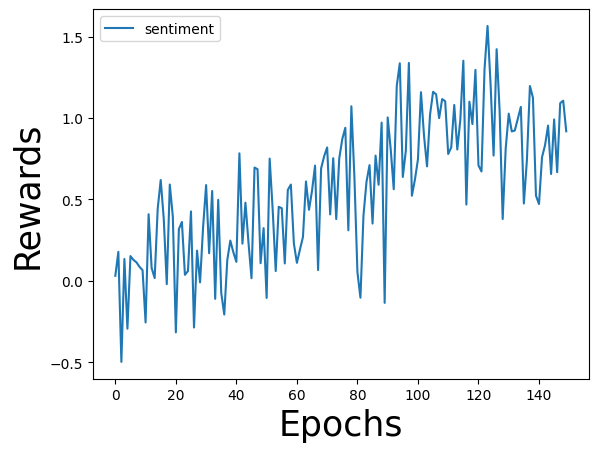

In [10]:
# instantiate the reinforcement learning trainer
reward_list = []

ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, gpt2_tokenizer, **config)

total_ppo_epochs = 150
batch_size = 32

for epoch, batch in tqdm(zip(range(total_ppo_epochs), iter(dataloader)), total = total_ppo_epochs):
    
    ### initiate logging dicts
    logs, timing = dict(), dict()
    t0 = time.time()
    
    ### get start sequence input tokens
    query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]
    
    ### Get responses from policy model
    t = time.time()
    response_tensors = []
    for i in range(batch_size):
        gen_len = output_size()
        query_tensor = query_tensors[i].unsqueeze(dim=0)
        response_tensor = respond_to_batch(gpt2_model, query_tensor, gen_len)
        response_tensors.append(response_tensor.squeeze())
        
    batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]
    timing['time/get_response'] = time.time()-t
    
    #### Compute sentiment score (reward)
    t = time.time()
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = torch.tensor([output[1]["score"] for output in pipe_outputs]).to(device)
    timing['time/get_sentiment_preds'] = time.time()-t
    
    reward_list.append(torch.mean(rewards).item())
    
    #### Run PPO step 
    t = time.time()
    train_stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
    
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Rewards', fontsize=25)
plt.plot(reward_list, label='sentiment')
plt.legend()
plt.show()

In [11]:
for i in range(len(batch["query"])):
    print(' ')
    print(batch["query"][i] + '  -->  ' + batch['response'][i])

 
Ok, I've seen  -->   partners, exchanges and, and hacks in the
 
"Ambushed" is  -->   a brilliant story from film
 
I don't know  -->   if anything is alive but I will definitely have
 
I loved Adrianne Curry before  -->   we became our Pies on December 13.

 
I do not watch much television  -->  , but I love it. It has been amazing
 
Adrianne, should really get  -->   back at the top of the game, and
 
I give this marriage  -->   a tremendous answer to all my work. It's incredible!
 
I really wanted to like this  -->  . I love that.
 
If you made a genre  -->   choice, you also will help us choose it for us.
 
I myself am a big fan  -->   of the way I take
 
*Contains some spoilers* This  -->   version tells Capcom a lot of modern Modern
 
After mob boss Vic  -->   Fangs is set to announce his new support for Battlefield 4.
 
I love John Saxon in  -->   my class. I really enjoy it. I love it
 
It seems like this is the  -->   Equal Rights Amendment.



Yes the Supreme Court is the
 